In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
import os

# Figure 5. Kendall's $\tau$ of the cases with different variances in $\mu$ and $\beta$.
## Sensitivity Analysis: Experiment with Ranking

In [2]:
def simulate_wealth(surnames, W0_values, mu_values, beta_values, times, groups):
    records = []
    for surname, W0, mu, beta, group in zip(surnames, W0_values, mu_values, beta_values, groups):
        for t in times:
            exp_part = (1 - beta**t) * mu
            wealth = np.exp(exp_part) * W0**(beta**t)
            log_wealth = np.log(wealth)
            log_random = np.random.normal(loc=0, scale=1)
            records.append({'Surname': surname, 
                            'Group': group,
                            'Time': t, 
                            'Wealth': wealth, 
                            'log_Wealth': log_wealth, 
                            'mu': mu, 
                            'beta': beta, 
                            'W0': W0, 
                            'log_random':log_random})
    return pd.DataFrame(records)

In [3]:
def parameter_setup(seed=40, mu_setup='fixed', beta_setup='bimodal', experiment_type='modality'):

    # Simulation parameters (As in the simulations above.)
    np.random.seed(seed)
    n_surnames = 100
    surnames = np.arange(n_surnames)
    times = range(1, 21)


    # Bimodal initial wealth
    high_initial_wealth = np.random.lognormal(mean=10, sigma=2, size=n_surnames//2)
    low_initial_wealth = np.random.lognormal(mean=-10, sigma=2, size=n_surnames//2)
    initial_wealth = np.concatenate([high_initial_wealth, low_initial_wealth])
    
    high = np.full(n_surnames//2, 'high')  #The order should remain the same but verify.
    low = np.full(n_surnames//2, 'low')
    groups = np.concatenate([high, low])
    
   
    if experiment_type == 'modality':
         #---------------------------------MU----------------------------------------
        if mu_setup == 'fixed':
            # Fixed mu
            mu_values = np.full(n_surnames, fill_value = 0)
            
        elif mu_setup == 'unimodal':
            mu_values = np.random.normal(0, 0.01, size = n_surnames)
            
        elif mu_setup == 'bimodal':
            mu_high = np.random.normal(10, 0.01, size = n_surnames//2) # For the high initial wealth 
            mu_low = np.random.normal(-10, 0.01, size = n_surnames//2) # For the low initial wealth
            mu_values = np.concatenate([mu_high, mu_low])
    
        elif mu_setup == 'uni_large':
            mu_values = np.random.normal(0, 100, size = n_surnames)
            
        else:
            None

        #-------------------------------BETA---------------------------------------
    
        if beta_setup == 'fixed':
            beta_values = np.full(n_surnames, 0.5)
    
        elif beta_setup == 'unimodal':
            beta_values = np.random.uniform(0.45, 0.55, size = n_surnames)
        
        elif beta_setup == 'bimodal':
            beta_values_high = np.random.uniform(0, 0.2, size=n_surnames//2) 
            beta_values_low = np.random.uniform(0.8, 1, size=n_surnames//2) 
            beta_values = np.concatenate([beta_values_high, beta_values_low]) 
    
        elif beta_setup == 'uni_large':
            beta_values = np.random.uniform(0, 1, size = n_surnames)
        
        else:
            None
    else:
        None

    if experiment_type == 'variance_size':
         #---------------------------------MU----------------------------------------
        if mu_setup == 'high':
            mu_values = np.random.normal(5, 5, size = n_surnames)
            
        elif mu_setup == 'low':
            mu_values = np.random.normal(5, 0.01, size = n_surnames)
            
        else:
            None

        #-------------------------------BETA---------------------------------------

        if beta_setup == 'high':
            beta_values = np.random.uniform(0, 1, size=n_surnames)
            
        elif beta_setup == 'low':
            beta_values = np.random.uniform(0.45, 0.55, size = n_surnames)

        else:
            None
    else:
        None

        
    # Population-wise convergence value
    mu_population = np.mean(mu_values)
    W0_population = np.mean(initial_wealth)
    beta_population = np.mean(beta_values)
    
    # Generate data
    df_scenario = simulate_wealth(surnames, initial_wealth, mu_values, beta_values, times, groups)
    population_data = simulate_wealth(['Population'], [W0_population], [mu_population], [beta_population], times, groups)

    return df_scenario, population_data

In [4]:
def preprocess_scenario(df_scenario):
    # Create the time zero dataframe
    df_time_zero = df_scenario[['Surname', 'Group', 'W0']].drop_duplicates().copy()
    df_time_zero['Time'] = 0
    df_time_zero['Wealth'] = df_time_zero['W0']  # Set Wealth to W0
    df_time_zero['log_Wealth'] = np.log(df_time_zero['W0'])  # Set log_Wealth to log(W0)
    df_time_zero['log_random'] = 0  # For the graph, it doesn't matter

    # Concatenate and sort
    df_scenario = pd.concat([df_scenario, df_time_zero], ignore_index=True)
    df_scenario = df_scenario.sort_values(by=['Surname', 'Time']).reset_index(drop=True)

    # Add log_Wealth_Random
    df_scenario['log_Wealth_Random'] = df_scenario['log_Wealth'] + df_scenario['log_random']

    # Rank wealth
    df_scenario['Wealth_Rank'] = df_scenario.groupby('Time')['log_Wealth_Random'].rank(ascending=False, method="first")

    # Shift rank to create previous rank
    df_scenario['Wealth_Rank_Prev'] = df_scenario.groupby(['Surname'])['Wealth_Rank'].shift(1)

    # Get the first rank at Time = 1
    temp = df_scenario[df_scenario['Time'] == 1][['Surname', 'Wealth_Rank']].copy()
    temp = temp.rename(columns={'Wealth_Rank': 'Wealth_Rank_first'})
    df_scenario = pd.merge(df_scenario, temp, on='Surname', how='left')

    # Filter out Time 0 for further analysis
    # df_scenario_withoutT0 = df_scenario[df_scenario['Time'] != 0].copy()

    # return df_scenario, df_scenario_withoutT0
    return df_scenario

In [5]:
# Initialize dictionaries to store data
df_scenarios = {}
population_data = {}
df_scenarios_withoutT0 = {}


# Loop over the seeds
np.random.seed(0)
seeds = np.random.randint(low=1, high=1000, size=30)
seeds = np.sort(seeds)

for seed in seeds:
    #------------------------------------------- Modality Experiments -------------------------------------------
    df_scenarios[f'df_scenario1_{seed}'], population_data[f'population_data1_{seed}'] = parameter_setup(seed=seed, mu_setup='fixed', beta_setup='bimodal', experiment_type = 'modality')
    df_scenarios[f'df_scenario2_{seed}'], population_data[f'population_data2_{seed}'] = parameter_setup(seed=seed, mu_setup='fixed', beta_setup='unimodal', experiment_type='modality')
    
    df_scenarios[f'df_scenario3_{seed}'], population_data[f'population_data3_{seed}'] = parameter_setup(seed=seed, mu_setup='bimodal', beta_setup='fixed', experiment_type='modality')
    df_scenarios[f'df_scenario4_{seed}'], population_data[f'population_data4_{seed}'] = parameter_setup(seed=seed, mu_setup='unimodal', beta_setup='fixed', experiment_type='modality')
    
    df_scenarios[f'df_scenario5_{seed}'], population_data[f'population_data5_{seed}'] = parameter_setup(seed=seed, mu_setup='bimodal', beta_setup='bimodal', experiment_type='modality')
    df_scenarios[f'df_scenario6_{seed}'], population_data[f'population_data6_{seed}'] = parameter_setup(seed=seed, mu_setup='unimodal', beta_setup='unimodal', experiment_type='modality')


    df_scenarios[f'df_scenario7_{seed}'], population_data[f'population_data7_{seed}'] = parameter_setup(seed=seed, mu_setup='unimodal', beta_setup='uni_large', experiment_type='modality')
    df_scenarios[f'df_scenario8_{seed}'], population_data[f'population_data8_{seed}'] = parameter_setup(seed=seed, mu_setup='uni_large', beta_setup='unimodal', experiment_type='modality')

    #------------------------------------------- Var. Size Experiments -------------------------------------------
    df_scenarios[f'df_scenario9_{seed}'], population_data[f'population_data9_{seed}'] = parameter_setup(seed=seed, mu_setup='low', beta_setup='low', experiment_type='variance_size') # Case A
    df_scenarios[f'df_scenario10_{seed}'], population_data[f'population_data10_{seed}'] = parameter_setup(seed=seed, mu_setup='high', beta_setup='low', experiment_type='variance_size') # Case B
    df_scenarios[f'df_scenario11_{seed}'], population_data[f'population_data11_{seed}'] = parameter_setup(seed=seed, mu_setup='low', beta_setup='high', experiment_type='variance_size') # Case C
    df_scenarios[f'df_scenario12_{seed}'], population_data[f'population_data12_{seed}'] = parameter_setup(seed=seed, mu_setup='high', beta_setup='high', experiment_type='variance_size') # Case D
    
    # Preprocessing
    df_scenarios[f'df_scenario1_{seed}'] = preprocess_scenario( df_scenarios[f'df_scenario1_{seed}'])
    df_scenarios[f'df_scenario2_{seed}'] = preprocess_scenario( df_scenarios[f'df_scenario2_{seed}'])
    df_scenarios[f'df_scenario3_{seed}'] = preprocess_scenario( df_scenarios[f'df_scenario3_{seed}'])
    df_scenarios[f'df_scenario4_{seed}'] = preprocess_scenario( df_scenarios[f'df_scenario4_{seed}'])
    df_scenarios[f'df_scenario5_{seed}'] = preprocess_scenario( df_scenarios[f'df_scenario5_{seed}'])
    df_scenarios[f'df_scenario6_{seed}'] = preprocess_scenario( df_scenarios[f'df_scenario6_{seed}'])
    df_scenarios[f'df_scenario7_{seed}'] = preprocess_scenario( df_scenarios[f'df_scenario7_{seed}'])
    df_scenarios[f'df_scenario8_{seed}'] = preprocess_scenario( df_scenarios[f'df_scenario8_{seed}'])

    df_scenarios[f'df_scenario9_{seed}'] = preprocess_scenario( df_scenarios[f'df_scenario9_{seed}'])
    df_scenarios[f'df_scenario10_{seed}'] = preprocess_scenario( df_scenarios[f'df_scenario10_{seed}'])
    df_scenarios[f'df_scenario11_{seed}'] = preprocess_scenario( df_scenarios[f'df_scenario11_{seed}'])
    df_scenarios[f'df_scenario12_{seed}'] = preprocess_scenario( df_scenarios[f'df_scenario12_{seed}'])


In [6]:
from scipy.stats import kendalltau

In [7]:
def calculate_tau(df, var='log_Wealth_Random', ref_time=0, df_name='df_scenario1'):
    corr = []
    for i in range(ref_time,21):
        x = df[df['Time']==ref_time][var]
        y = df[df['Time']==i][var]
        tau, _ = kendalltau(x, y) 
        corr.append({'Time_compared': i, 'tau': tau, 'Scenario': df_name})  
    return corr

## Calculate Tau for Modality Experiments

In [8]:
seeds

array([ 10,  71,  73,  88, 175, 193, 278, 315, 360, 397, 473, 487, 538,
       552, 560, 600, 601, 601, 630, 678, 685, 706, 708, 724, 755, 764,
       805, 836, 846, 850])

In [9]:
scenarios = range(1,9)

all_results = pd.DataFrame()

for seed in seeds:
    for scenario in scenarios:
        df = df_scenarios[f'df_scenario{scenario}_{seed}']
        result = calculate_tau(df, var='log_Wealth', ref_time=0, df_name=f'df_scenario{scenario}_seed{seed}')
        result_df = pd.DataFrame(result)
        result_df['Seed'] = seed
        result_df['Scenario'] = scenario
        all_results = pd.concat([result_df, all_results], ignore_index=True)

In [10]:
all_results = all_results.sort_values(['Seed', 'Scenario', 'Time_compared'], ignore_index=True)

In [11]:
all_results

Time_compared       tau  Scenario  Seed
0                 0  1.000000         1    10
1                 1  0.787071         1    10
2                 2  0.725657         1    10
3                 3  0.678384         1    10
4                 4  0.648889         1    10
...             ...       ...       ...   ...
5035             16  0.039192         8   850
5036             17  0.039192         8   850
5037             18  0.039192         8   850
5038             19  0.039192         8   850
5039             20  0.039192         8   850

[5040 rows x 4 columns]

In [12]:
scenarios = range(1,9)

all_results_rank = pd.DataFrame()

for seed in seeds:
    for scenario in scenarios:
        df = df_scenarios[f'df_scenario{scenario}_{seed}']
        result = calculate_tau(df, var='Wealth_Rank', ref_time=0, df_name=f'df_scenario{scenario}_seed{seed}')
        result_df = pd.DataFrame(result)
        result_df['Seed'] = seed
        result_df['Scenario'] = scenario
        all_results_rank = pd.concat([result_df, all_results_rank], ignore_index=True)

In [13]:
all_results_rank = all_results_rank.sort_values(['Seed', 'Scenario', 'Time_compared'], ignore_index=True)

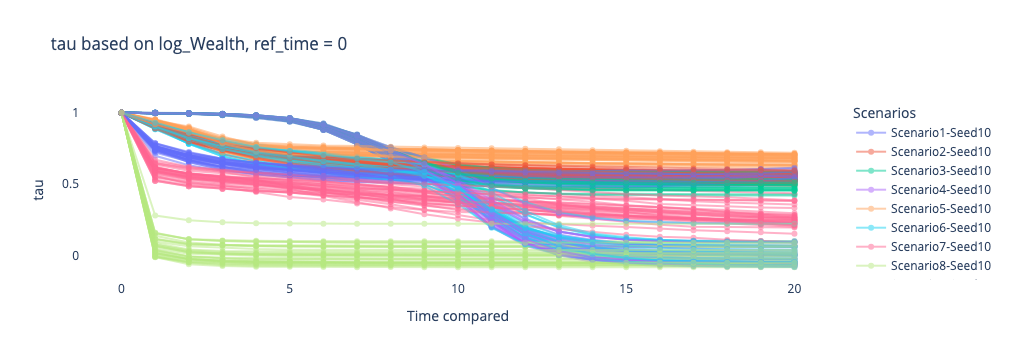

In [14]:
fig = go.Figure()

colors = px.colors.qualitative.Plotly  # or any other color palette
scenario_colors = {scenario: colors[i % len(colors)] for i, scenario in enumerate(all_results_rank['Scenario'].unique())}


for seed in seeds:
    # for i in all_results['Scenario'].unique():
    for i in range(1,9):
        df = all_results[(all_results['Scenario'] == i) & (all_results['Seed'] == seed)]
        fig.add_trace(
            go.Scatter(
                x=df['Time_compared'],
                y=df['tau'],
                mode = 'lines+markers',
                name = f'Scenario{i}-Seed{seed}',
                opacity = 0.5, 
                line = dict(color = scenario_colors[i])
                
            )
            )
fig.update_layout(
    title = 'tau based on log_Wealth, ref_time = 0',
    xaxis_title='Time compared',
    yaxis_title='tau',
    legend_title='Scenarios',
    # font_family="Times New Roman",
    # title_font_family="Times New Roman",
    showlegend=True,
   
    # margin=dict(l=10, r=10, t=10, b=10),
    # paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor = 'rgba(0,0,0,0)'
)

fig.show()

In [15]:
mean_rank_modality = all_results_rank.groupby(['Time_compared', 'Scenario'])['tau'].agg(['mean', 'std']).reset_index()
mean_rank_modality

Time_compared  Scenario      mean       std
0                0         1  1.000000  0.000000
1                0         2  1.000000  0.000000
2                0         3  1.000000  0.000000
3                0         4  1.000000  0.000000
4                0         5  1.000000  0.000000
..             ...       ...       ...       ...
163             20         4 -0.032202  0.065202
164             20         5  0.555731  0.027290
165             20         6 -0.015354  0.056300
166             20         7  0.096458  0.055215
167             20         8  0.003946  0.068028

[168 rows x 4 columns]

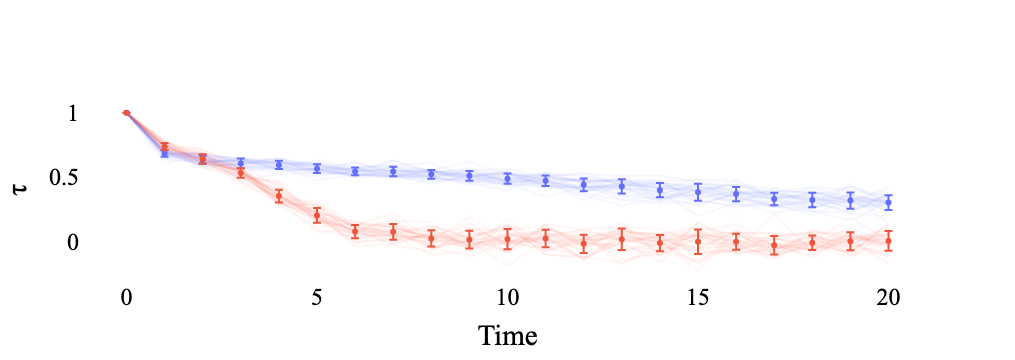

In [16]:
fig = go.Figure()

colors = px.colors.qualitative.Plotly  # or any other color palette
scenario_colors = {scenario: colors[i % len(colors)] for i, scenario in enumerate(all_results_rank['Scenario'].unique())}

scenario_to_see = [1,2] #Set the scenarios to see

for seed in seeds:
    for i in scenario_to_see:
        df = all_results_rank[(all_results_rank['Scenario'] == i) & (all_results_rank['Seed'] == seed)]
        fig.add_trace(
            go.Scatter(
                x=df['Time_compared'],
                y=df['tau'],
                mode = 'lines',
                name = f'Scenario{i}-Seed{seed}',
                opacity = 0.05,
                line = dict(color = scenario_colors[i])
            )
        )

for i in scenario_to_see:
    scenario_mean_rank = mean_rank_modality[mean_rank_modality['Scenario'] == i]  
    fig.add_trace(
        go.Scatter(
            x=scenario_mean_rank['Time_compared'],
            y=scenario_mean_rank['mean'],
            error_y=dict(
                type='data',  
                array=scenario_mean_rank['std'], 
                arrayminus=scenario_mean_rank['std'],  
            ),
            mode='markers',
            name=f'Scenario {i}',
            opacity=1,
            marker=dict(color=scenario_colors[i]) 
        )
    )


fig.update_layout(
    # title = 'tau based on Wealth_Rank, ref_time = 0',
    xaxis_title='Time',
    yaxis_title='&#964;',
    legend_title='Scenarios',
    font_family="Times New Roman",
    title_font_family="Times New Roman",
    font_size = 24,
    font_color = 'black',
    showlegend=False,
    # margin=dict(l=10, r=10, t=10, b=10),
    # paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor = 'rgba(0,0,0,0)'
)


fig.show()

## Calculate Tau for Variance Size Experiments

In [17]:
scenarios = range(9,13)

all_results_var = pd.DataFrame()

for seed in seeds:
    for scenario in scenarios:
        df = df_scenarios[f'df_scenario{scenario}_{seed}']
        result = calculate_tau(df, var='log_Wealth', ref_time=0, df_name=f'df_scenario{scenario}_seed{seed}')
        result_df = pd.DataFrame(result)
        result_df['Seed'] = seed
        result_df['Scenario'] = scenario
        all_results_var = pd.concat([result_df, all_results_var], ignore_index=True)

In [18]:
all_results_var = all_results_var.sort_values(['Seed', 'Scenario', 'Time_compared'], ignore_index=True)

In [19]:
all_results_var_rank = pd.DataFrame()

for seed in seeds:
    for scenario in scenarios:
        df = df_scenarios[f'df_scenario{scenario}_{seed}']
        result = calculate_tau(df, var='Wealth_Rank', ref_time=0, df_name=f'df_scenario{scenario}_seed{seed}')
        result_df = pd.DataFrame(result)
        result_df['Seed'] = seed
        result_df['Scenario'] = scenario
        all_results_var_rank = pd.concat([result_df, all_results_var_rank], ignore_index=True)

In [20]:
all_results_var_rank = all_results_var_rank.sort_values(['Seed', 'Scenario', 'Time_compared'], ignore_index=True)

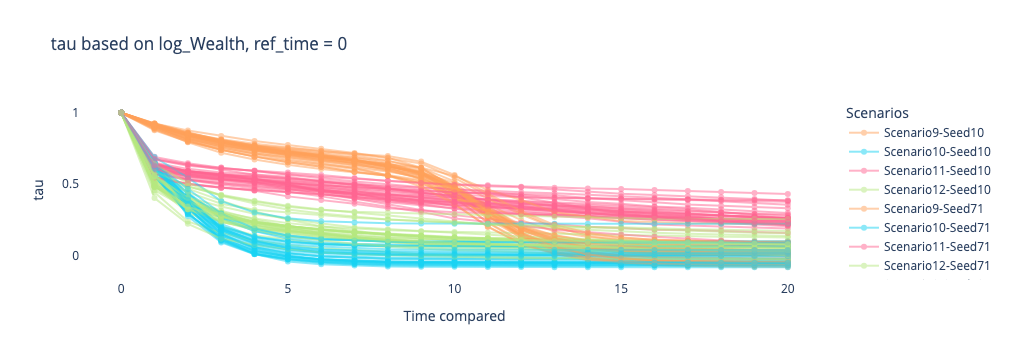

In [21]:
fig = go.Figure()

colors = px.colors.qualitative.Plotly  # or any other color palette
scenario_colors = {9: colors[4], 10: colors[5], 11: colors[6], 12: colors[7]}


for seed in seeds:
    for i in range(9,13):
        df = all_results_var[(all_results_var['Scenario'] == i) & (all_results_var['Seed'] == seed)]
        fig.add_trace(
            go.Scatter(
                x=df['Time_compared'],
                y=df['tau'],
                mode = 'lines+markers',
                name = f'Scenario{i}-Seed{seed}',
                opacity = 0.5, 
                line = dict(color = scenario_colors[i])
                
            )
            )
fig.update_layout(
    title = 'tau based on log_Wealth, ref_time = 0',
    xaxis_title='Time compared',
    yaxis_title='tau',
    legend_title='Scenarios',
    # font_family="Times New Roman",
    # title_font_family="Times New Roman",
    showlegend=True,
   
    # margin=dict(l=10, r=10, t=10, b=10),
    # paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor = 'rgba(0,0,0,0)'
)

fig.show()

In [22]:
mean_rank = all_results_var_rank.groupby(['Time_compared', 'Scenario'])['tau'].agg(['mean', 'std']).reset_index()
mean_rank

Time_compared  Scenario      mean       std
0               0         9  1.000000  0.000000
1               0        10  1.000000  0.000000
2               0        11  1.000000  0.000000
3               0        12  1.000000  0.000000
4               1         9  0.738182  0.024434
..            ...       ...       ...       ...
79             19        12  0.061872  0.059441
80             20         9 -0.015354  0.056300
81             20        10  0.002801  0.069350
82             20        11  0.091758  0.056882
83             20        12  0.059596  0.061388

[84 rows x 4 columns]

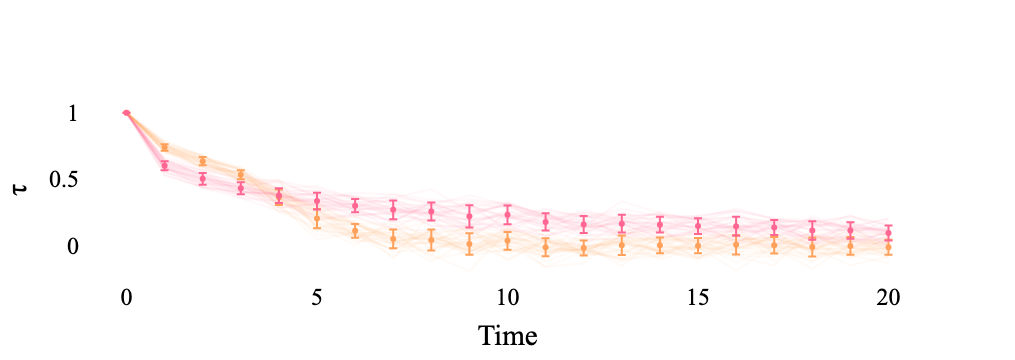

In [23]:
fig = go.Figure()

colors = px.colors.qualitative.Plotly  # or any other color palette
scenario_colors = {9: colors[4], 10: colors[5], 11: colors[6], 12: colors[7]}

scenario_to_see = [9,11]

for seed in seeds:
    for i in scenario_to_see:
        df = all_results_var_rank[(all_results_var_rank['Scenario'] == i) & (all_results_var_rank['Seed'] == seed)]
        fig.add_trace(
            go.Scatter(
                x=df['Time_compared'],
                y=df['tau'],
                mode = 'lines',
                name = f'Scenario{i}-Seed{seed}',
                opacity = 0.05,
                line = dict(color = scenario_colors[i])
            )
        )

for i in scenario_to_see:
    scenario_mean_rank = mean_rank[mean_rank['Scenario'] == i]  
    fig.add_trace(
        go.Scatter(
            x=scenario_mean_rank['Time_compared'],
            y=scenario_mean_rank['mean'],
            error_y=dict(
                type='data',  
                array=scenario_mean_rank['std'], 
                arrayminus=scenario_mean_rank['std'],  
            ),
            mode='markers',
            name=f'Scenario {i}',
            opacity=1,
            marker=dict(color=scenario_colors[i]) 
        )
    )



fig.update_layout(
    # title = 'tau based on Wealth_Rank, ref_time = 0',
    xaxis_title='Time',
    yaxis_title='&#964;',
    legend_title='Scenarios',
    font_family="Times New Roman",
    title_font_family="Times New Roman",
    font_size = 24,
    font_color = 'black',
    showlegend=False,
    # margin=dict(l=10, r=10, t=10, b=10),
    # paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor = 'rgba(0,0,0,0)'
)


fig.show()

# Figure 3. The relationship between variances of subgroup-wise $\mu$ and $\beta$.

In [24]:
s9 = df_scenarios['df_scenario9_10']
pop9 = population_data['population_data9_10']

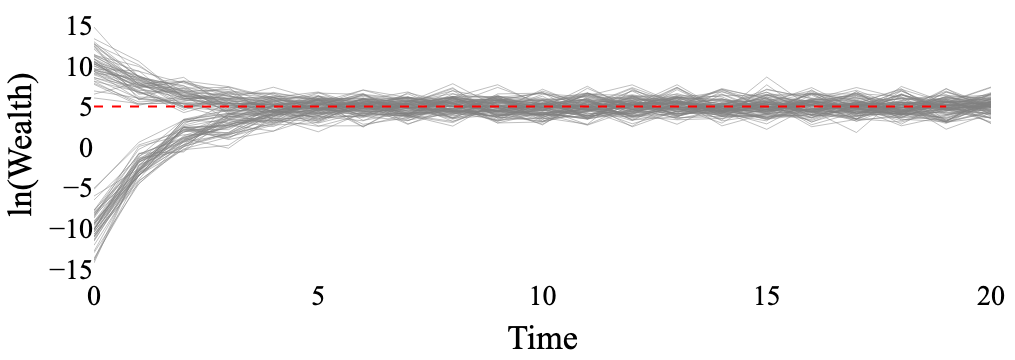

In [27]:
fig = go.Figure()

df_high = s9[s9['Group'] == 'high']
for i in df_high['Surname'].unique():
    df_nid = df_high[df_high['Surname'] == i]
    fig.add_trace(go.Scatter(
        x=df_nid['Time'], 
        y=df_nid['log_Wealth_Random'], 
        mode='lines', 
        name=f'Surname {i} (High)',
        opacity=0.5,
        # line=dict(width=1, color='#009392')
        line=dict(width=1, color='grey')
    ))


df_low = s9[s9['Group'] == 'low']
for i in df_low['Surname'].unique():
    df_nid = df_low[df_low['Surname'] == i]
    fig.add_trace(go.Scatter(
        x=df_nid['Time'], 
        y=df_nid['log_Wealth_Random'], 
        mode='lines', 
        name=f'Surname {i} (Low)',
        opacity=0.5,
        # line=dict(width=1, color='#cf597e')
        line=dict(width=1, color='grey')
    ))

# fig.add_trace(go.Scatter(
#     x=s9['Time'], 
#     y=s9['log_Wealth_Random'], 
#     mode='markers', 
#     name='All Surnames',
#     opacity=0.8,
#     marker=dict(
#         color=s9['Wealth_Rank_first'],  
#         colorscale='Temps',  
#         # colorbar=dict(title="Wealth Rank") 
#     )
# ))


# Add the trace for the 'mu' line
fig.add_trace(go.Scatter(x=s9['Time'], 
                         y=pop9['mu'],
                         mode='lines', 
                         name='mu', 
                         line=dict(color='red', dash='dash', width=2)))


fig.update_layout(
    xaxis_title='Time',
    yaxis_title='ln(Wealth)',
    legend_title='Surnames',
    font_family="Times New Roman",
    title_font_family="Times New Roman",
    font_size = 28,
    font_color = 'black',
    showlegend=False,
    margin=dict(l=10, r=10, t=10, b=10),
    # paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor = 'rgba(0,0,0,0)'
)

fig.show()


In [28]:
s10 = df_scenarios['df_scenario10_10']
pop10 = population_data['population_data10_10']

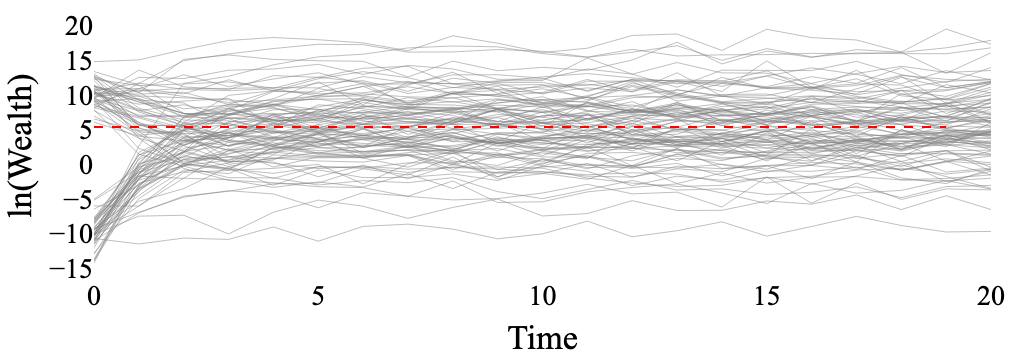

In [29]:
fig = go.Figure()

df_high = s10[s10['Group'] == 'high']
for i in df_high['Surname'].unique():
    df_nid = df_high[df_high['Surname'] == i]
    fig.add_trace(go.Scatter(
        x=df_nid['Time'], 
        y=df_nid['log_Wealth_Random'], 
        mode='lines', 
        name=f'Surname {i} (High)',
        opacity=0.5,
        line=dict(width=1, color='grey')
    ))


df_low = s10[s10['Group'] == 'low']
for i in df_low['Surname'].unique():
    df_nid = df_low[df_low['Surname'] == i]
    fig.add_trace(go.Scatter(
        x=df_nid['Time'], 
        y=df_nid['log_Wealth_Random'], 
        mode='lines', 
        name=f'Surname {i} (Low)',
        opacity=0.5,
        line=dict(width=1, color='grey')
    ))

# fig.add_trace(go.Scatter(
#     x=s10['Time'], 
#     y=s10['log_Wealth_Random'], 
#     mode='markers', 
#     name='All Surnames',
#     opacity=0.8,
#     marker=dict(
#         color=s10['Wealth_Rank_first'],  
#         colorscale='Temps',  
#         # colorbar=dict(title="Wealth Rank") 
#     )
# ))


# Add the trace for the 'mu' line
fig.add_trace(go.Scatter(x=s10['Time'], 
                         y=pop10['mu'],
                         mode='lines', 
                         name='mu', 
                         line=dict(color='red', dash='dash', width=2)))


fig.update_layout(
    xaxis_title='Time',
    yaxis_title='ln(Wealth)',
    legend_title='Surnames',
    font_family="Times New Roman",
    title_font_family="Times New Roman",
    font_size = 28,
    font_color='black',
    showlegend=False,
    margin=dict(l=10, r=10, t=10, b=10),
    # paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor = 'rgba(0,0,0,0)'
)

fig.show()


In [30]:
s11 = df_scenarios['df_scenario11_10']
pop11 = population_data['population_data11_10']

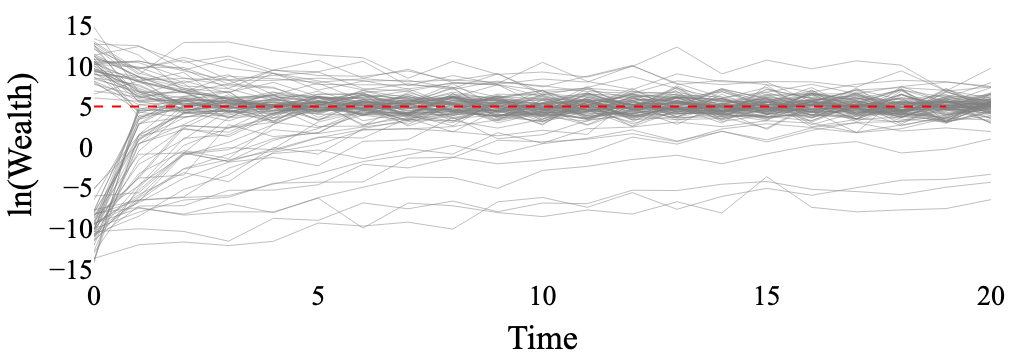

In [31]:
fig = go.Figure()

df_high = s11[s11['Group'] == 'high']
for i in df_high['Surname'].unique():
    df_nid = df_high[df_high['Surname'] == i]
    fig.add_trace(go.Scatter(
        x=df_nid['Time'], 
        y=df_nid['log_Wealth_Random'], 
        mode='lines', 
        name=f'Surname {i} (High)',
        opacity=0.5,
        line=dict(width=1, color='grey')
    ))


df_low = s11[s11['Group'] == 'low']
for i in df_low['Surname'].unique():
    df_nid = df_low[df_low['Surname'] == i]
    fig.add_trace(go.Scatter(
        x=df_nid['Time'], 
        y=df_nid['log_Wealth_Random'], 
        mode='lines', 
        name=f'Surname {i} (Low)',
        opacity=0.5,
        line=dict(width=1, color='grey')
    ))

# fig.add_trace(go.Scatter(
#     x=s11['Time'], 
#     y=s11['log_Wealth_Random'], 
#     mode='markers', 
#     name='All Surnames',
#     opacity=0.8,
#     marker=dict(
#         color=s11['Wealth_Rank_first'],  
#         colorscale='Temps',  
#         # colorbar=dict(title="Wealth Rank") 
#     )
# ))


# Add the trace for the 'mu' line
fig.add_trace(go.Scatter(x=s11['Time'], 
                         y=pop11['mu'],
                         mode='lines', 
                         name='mu', 
                         line=dict(color='red', dash='dash', width=2)))


fig.update_layout(
    xaxis_title='Time',
    yaxis_title='ln(Wealth)',
    legend_title='Surnames',
    font_family="Times New Roman",
    title_font_family="Times New Roman",
    font_size = 28,
    font_color='black',
    showlegend=False,
    margin=dict(l=10, r=10, t=10, b=10),
    # paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor = 'rgba(0,0,0,0)'
)

fig.show()


In [32]:
s12 = df_scenarios['df_scenario12_10']
pop12 = population_data['population_data12_10']

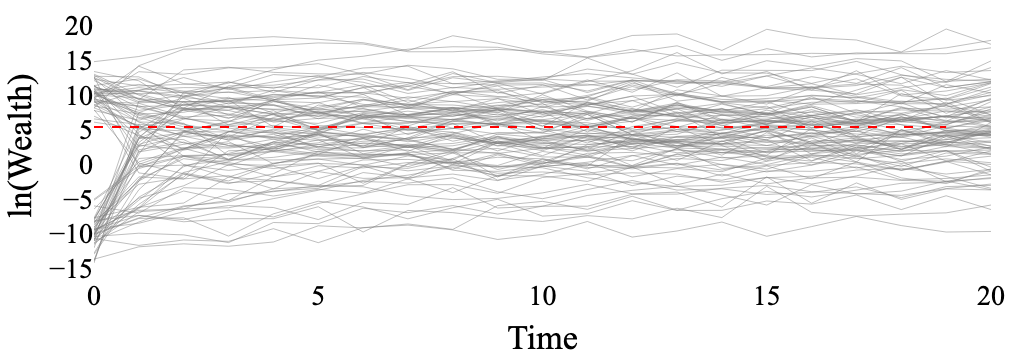

In [33]:
fig = go.Figure()

df_high = s12[s12['Group'] == 'high']
for i in df_high['Surname'].unique():
    df_nid = df_high[df_high['Surname'] == i]
    fig.add_trace(go.Scatter(
        x=df_nid['Time'], 
        y=df_nid['log_Wealth_Random'], 
        mode='lines', 
        name=f'Surname {i} (High)',
        opacity=0.5,
        line=dict(width=1, color='grey')
    ))


df_low = s12[s12['Group'] == 'low']
for i in df_low['Surname'].unique():
    df_nid = df_low[df_low['Surname'] == i]
    fig.add_trace(go.Scatter(
        x=df_nid['Time'], 
        y=df_nid['log_Wealth_Random'], 
        mode='lines', 
        name=f'Surname {i} (Low)',
        opacity=0.5,
        line=dict(width=1, color='grey')
    ))

# fig.add_trace(go.Scatter(
#     x=s12['Time'], 
#     y=s12['log_Wealth_Random'], 
#     mode='markers', 
#     name='All Surnames',
#     opacity=0.8,
#     marker=dict(
#         color=s12['Wealth_Rank_first'],  
#         colorscale='Temps',  
#         # colorbar=dict(title="Wealth Rank") 
#     )
# ))


# Add the trace for the 'mu' line
fig.add_trace(go.Scatter(x=s12['Time'], 
                         y=pop12['mu'],
                         mode='lines', 
                         name='mu', 
                         line=dict(color='red', dash='dash', width=2)))


fig.update_layout(
    xaxis_title='Time',
    yaxis_title='ln(Wealth)',
    legend_title='Surnames',
    font_family="Times New Roman",
    title_font_family="Times New Roman",
    font_size = 28,
    font_color='black',
    showlegend=False,
    margin=dict(l=10, r=10, t=10, b=10),
    # paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor = 'rgba(0,0,0,0)'
)

fig.show()
